# Определение стоимости автомобилей

## Подготовка данных

### Загрузка данных

In [ ]:
!pip install catboost
!pip install ipywidgets
!pip install lightgbm

In [2]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import time

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, cv
from catboost import *
import catboost
from lightgbm import LGBMRegressor

In [4]:
df = pd.read_csv('/datasets/autos.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Признаки
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак:
- `Price` — цена (евро)

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
# список колонок с пропусками
[x for x in list(df.columns) if df[x].count() != len(df)]

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

**Вывод**

- Есть пропуски в трех колонках типа object: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`
- Стиль названия колонок не соответсвуем snake_case
- Колонки с датами и временем имеют строковый тип данных (что не всегда является проблемой)

### Названия колонок

In [8]:
# функция для преобразоания верблюжего регистра в змеиный
def snake_case(columns):
    list1 = []
    for column in columns:
        # разделение названия колонки на слова по заглавным буквам
        split_name = re.sub(r'([A-Z])', r' \1', column).split()
        # соединяе слова из названия через _ и делаем все буквы строчными
        list1.append('_'.join(split_name).lower())
    return list1

In [9]:
# переименование столбцов
df.set_axis(snake_case(list(df.columns)), axis=1, inplace = True)
# проверка
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Пропуски

In [10]:
df.isna().agg(['sum', 'mean']).T.style.format({'mean': '{:.2%}'})

,sum,mean
date_crawled,0,0.00%
price,0,0.00%
vehicle_type,37490,10.58%
registration_year,0,0.00%
gearbox,19833,5.60%
power,0,0.00%
model,19705,5.56%
kilometer,0,0.00%
registration_month,0,0.00%
fuel_type,32895,9.28%


Поскольку все пропуски в столбцах с типом данных object и достоверного способа восстановить их нет, выделим их в группу 'unidentified', заполнив этим значением пропуски.

In [11]:
df = df.fillna('unidentified')
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

### Дубликаты

In [12]:
# наличие дубликатов
df.duplicated().sum()

4

In [13]:
# удаление дубликатов и проверка на наличие
df = df.drop_duplicates().reset_index(drop= True)
df.duplicated().sum()

0

### Преобразование типов

In [14]:
# преобразование в дату
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')

### Первичный анализ данных

In [15]:
#!pip install sweetviz
#import sweetviz as sv

#report = sv.analyze([df, "full table"])
#report.show_notebook(w=940, h=550, scale=0.9)

In [16]:
def data_types(df):
    '''
    Функция для сортировки столбцов по типам данных. 
    Принимает таблицу, возвращает кортеж списков с назвниями колонок:
    1 - список колонок с данными типа object,
    2 - список колонок с числовыми данными,
    3 - список колонок с данными типа bool,
    4 - остальное
    '''
    list_obj = []
    list_num = []
    list_bool = []
    list_other = []
    
    for i in range(len(df.dtypes)):
        if df.dtypes[i] == object:
            list_obj.append(df.dtypes.index[i])
        elif df.dtypes[i] == int or df.dtypes[i] == float:
            list_num.append(df.dtypes.index[i])
        elif df.dtypes[i] == bool:
            list_bool.append(df.dtypes.index[i])
        else:
            list_other.append(df.dtypes.index[i])
            
    return list_obj, list_num, list_bool, list_other

In [17]:
# отделяем числовые и строковые столбцы
obj_columns, num_columns = data_types(df)[0:2]
date_columns = data_types(df)[3]

#### категориальные


                             vehicle_type                             
count     354365
unique         9
top        sedan
freq       91457
Name: vehicle_type, dtype: object


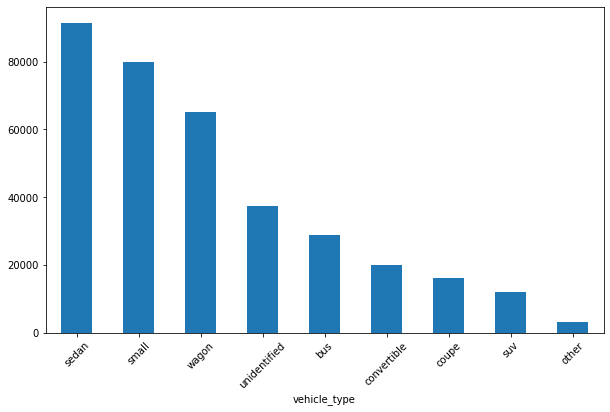


                               gearbox                                
count     354365
unique         3
top       manual
freq      268249
Name: gearbox, dtype: object


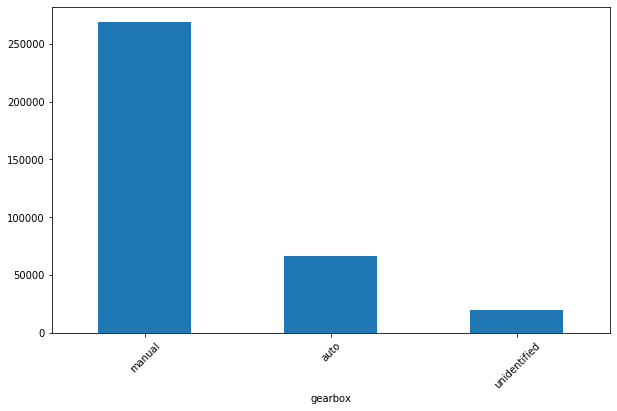


                                model                                 
count     354365
unique       251
top         golf
freq       29232
Name: model, dtype: object


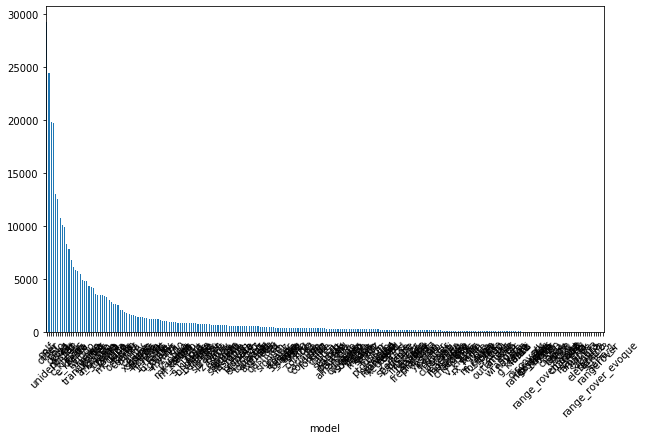


                              fuel_type                               
count     354365
unique         8
top       petrol
freq      216349
Name: fuel_type, dtype: object


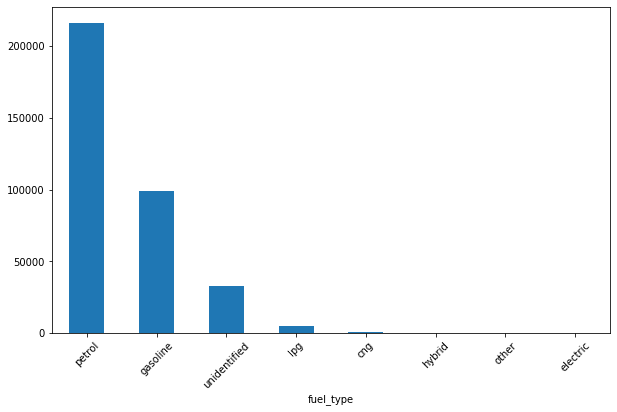


                                brand                                 
count         354365
unique            40
top       volkswagen
freq           77012
Name: brand, dtype: object


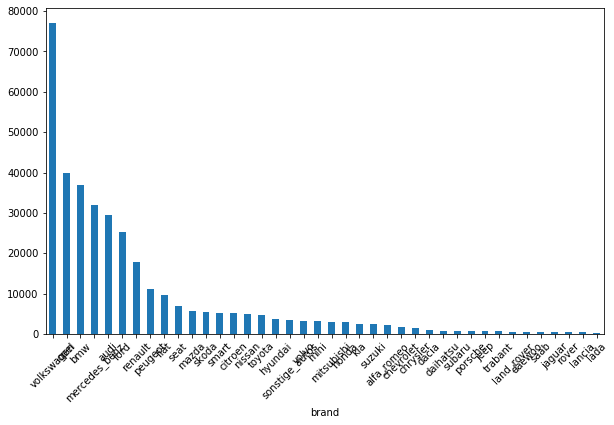


                             not_repaired                             
count     354365
unique         3
top           no
freq      247158
Name: not_repaired, dtype: object


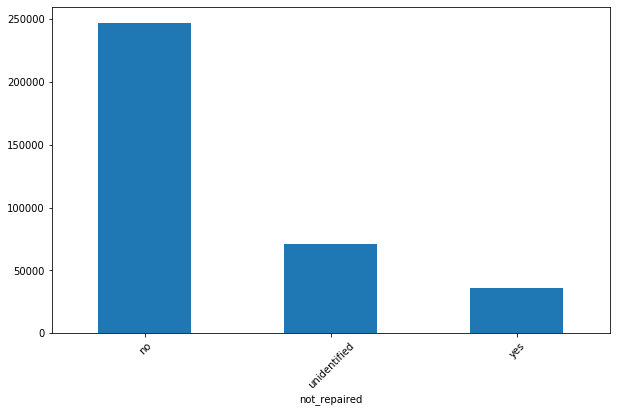

In [18]:
# смотрим на уникальные значения 
for i in obj_columns:
    print(f'\n{i:^70}')
    print(df[i].describe())
    df[i].value_counts(ascending=False).plot(kind='bar', rot=45, figsize=(10,6))
    plt.xlabel(i)
    plt.show()

In [19]:
df['model'].unique()

array(['golf', 'unidentified', 'grand', 'fabia', '3er', '2_reihe',
       'other', 'c_max', '3_reihe', 'passat', 'navara', 'ka', 'polo',
       'twingo', 'a_klasse', 'scirocco', '5er', 'meriva', 'arosa', 'c4',
       'civic', 'transporter', 'punto', 'e_klasse', 'clio', 'kadett',
       'kangoo', 'corsa', 'one', 'fortwo', '1er', 'b_klasse', 'signum',
       'astra', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', '156', 'escort', 'forester', 'xc_reihe', 'scenic',
       'a4', 'a1', 'insignia', 'combo', 'focus', 'tt', 'a6', 'jazz',
       'omega', 'slk', '7er', '80', '147', '100', 'z_reihe', 'sportage',
       'sorento', 'v40', 'ibiza', 'mustang', 'eos', 'touran', 'getz',
       'a3', 'almera', 'megane', 'lupo', 'r19', 'zafira', 'caddy',
       'mondeo', 'cordoba', 'colt', 'impreza', 'vectra', 'berlingo',
       'tiguan', 'i_reihe', 'espace', 'sharan', '6_reihe', 'panda', 'up',
       'seicento', 'ceed', '5_reihe', 'yeti', 'octavia', 'mii',
       'rx_reihe', '6e

Типов топлива довольно много, причем для бензина два названия ('gasoline', 'petrol'), для газа (разного типа) - тоже. Сделаем 4 группы: бензин, топливо, другое, неизвестно

In [20]:
# замена значений в столце 
df['fuel_type'].replace('gasoline','petrol',inplace=True)
df['fuel_type'].replace(['lpg', 'cng'],'gas',inplace=True)
df['fuel_type'].replace(['hybrid', 'electric'],'other',inplace=True)

In [21]:
df['fuel_type'].unique()

array(['petrol', 'unidentified', 'gas', 'other'], dtype=object)


                                price                                 
count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64


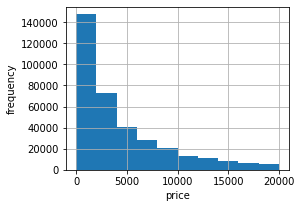


                          registration_year                           
count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64


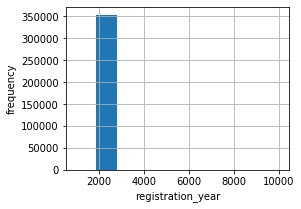


                                power                                 
count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


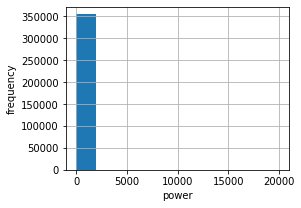


                              kilometer                               
count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


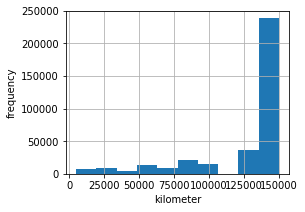


                          registration_month                          
count    354365.000000
mean          5.714650
std           3.726432
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64


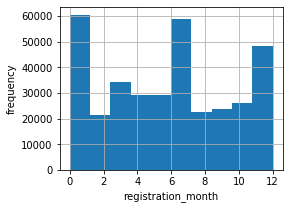


                          number_of_pictures                          
count    354365.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64


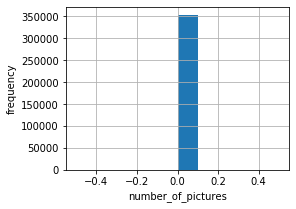


                             postal_code                              
count    354365.000000
mean      50508.503800
std       25783.100078
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: postal_code, dtype: float64


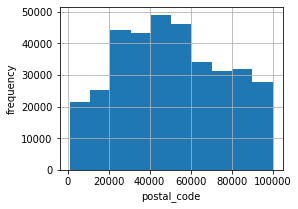

In [22]:
# смотрим на распределения и описания числовых столбцов
for i in num_columns:
    print(f'\n{i:^70}')
    print(df[i].describe())
    df[i].hist(figsize=(4, 3))
    plt.xlabel(i)
    plt.ylabel('frequency')
    plt.show()

**Выводы**

- В столбце `number_of_pictures` все значения равны 0. Этот стобец не несет какой-либо информации
- В столбце `registration_year` есть значение 1000 и 9999. Это надо проверить
- В столбце `price` есть нулевые значения. Их надо проверить
- В столбце `power` есть и нулевые значения, и очень большие. Их надо проверить
- В столбце `registration_month` есть номер месяца 0. Количество таких строк сопоставимо с кол-вом строк для других месяцов. Скорее всего нуль является маркером того, что автор анкеты не знает эту информацию или не стал ее указывать.

#### registration_year

In [23]:
# доля объявлений, год регистрации автомобиля в которых до 1900
df.query('registration_year < 1900')['date_crawled'].count() / len(df) * 100

0.018624864193698586

In [24]:
np.quantile(df['registration_year'], 0.05)

1992.0

При том, что ни одно объявление не выложено после 2016 года, в столбце "дата регистрации авто" есть более поздние даты, чего не может быть на самом деле

In [25]:
# доля автомобилей, зарегистированных после 2016 года
df.query('registration_year > 2016')['date_crawled'].count() / len(df) * 100

4.100292071733946

Оставим только объявления, дата регистрации автомобилей в которых в пределах от 1992 (чтобы не было длинного хвоста) до 2016.

In [26]:
df = df.query('registration_year <= 2016')

In [27]:
df = df[df['registration_year'] >=  np.quantile(df['registration_year'], 0.05)]

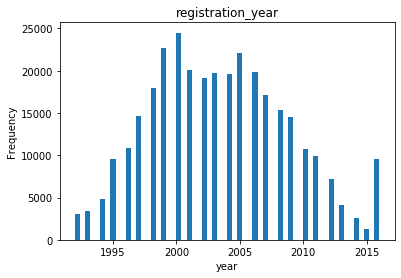

In [28]:
df['registration_year'].plot(kind='hist', bins=60)
plt.title('registration_year')
plt.xlabel('year')
plt.show()

#### power 

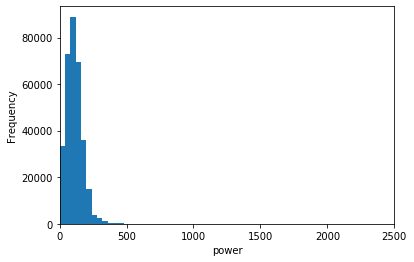

In [29]:
# распределение объявлений по указанной мощности
df['power'].plot(kind='hist', bins=500)
plt.xlim(0, 2500)
plt.xlabel('power')
plt.show()

In [30]:
df['power'].describe()

count    324598.000000
mean        112.156754
std         183.674678
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [31]:
# доля объявлений, где мощность более 400 л.с. 
print('объявления, где мощность более 400 л.с.')
print('%', round(df.query('power > 400')['date_crawled'].count() / len(df) * 100, 2))

объявления, где мощность более 400 л.с.
% 0.2


На момент публикаций объявлений (2016г) самое большая мощность  2500 л.с. у Dagger GT (2010 год выпуска), причем автомобили с огрромной мощностью, зачастую, не серийные. В таблице их сотни, что достаточно много для такого сегмента. Кроме того, стоит обратить внимание на их стоимость

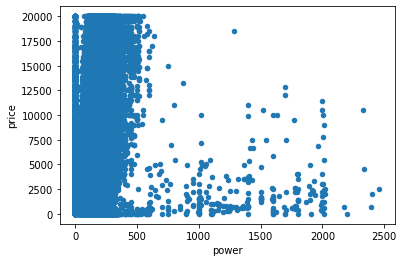

In [32]:
df.query('power < 2500').plot(x='power', y='price', kind='scatter')
plt.show()

Большинство точек сосредоточено до 500 л.с., причем после 500 л.с. цены не достигают больших значений.

На графике видно, что есть довольно много автомобилей, чью мощность оценивают в 0 л.с. Вероятнее всего, продавцы не знают мощность. Оставим эти объявления, тем более что их 10%

In [33]:
# доля объявлений, где мощность = 0 л.с.
df.query('power == 0')['date_crawled'].count() / len(df) * 100

10.164264721286022

In [34]:
np.quantile(df['power'], 0.95)

218.0

In [35]:
df = df[df['power'] < np.quantile(df['power'], 0.95)]

#### price

In [36]:
df.query('price < 100')['price'].count() / len(df) * 100

3.436542708846471

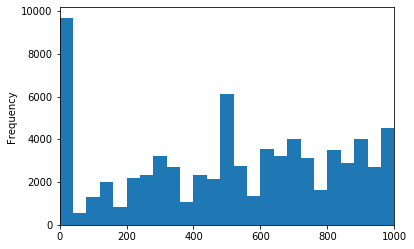

In [37]:
# гистограмма
df['price'].plot(kind='hist', bins=500)
plt.xlim(0, 1000)
plt.show()

In [38]:
df['price'].describe()

count    306529.000000
mean       4164.449449
std        4271.758682
min           0.000000
25%        1000.000000
50%        2590.000000
75%        5900.000000
max       20000.000000
Name: price, dtype: float64

In [39]:
np.quantile(df['price'], 0.9)

10500.0

In [40]:
np.quantile(df['price'], 0.05)

200.0

In [41]:
df = df[df['price'] > np.quantile(df['price'], 0.05)]

In [42]:
df = df[df['price'] < np.quantile(df['price'], 0.9)]

In [43]:
# % оставшихся строк
len(df) / 354369  * 100

73.6763091579681

#### Даты


                             date_crawled                             
count                  261086
unique                 214907
top       2016-03-20 16:50:22
freq                        5
first     2016-03-05 14:06:24
last      2016-04-07 14:36:58
Name: date_crawled, dtype: object


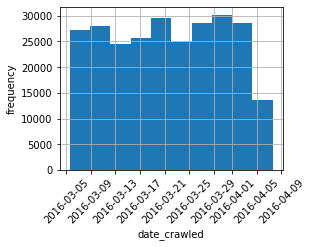


                             date_created                             
count                  261086
unique                    102
top       2016-04-03 00:00:00
freq                    10082
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: date_created, dtype: object


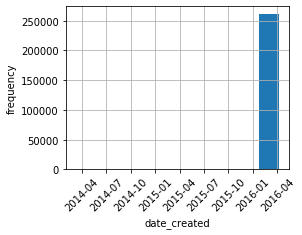


                              last_seen                               
count                  261086
unique                 146992
top       2016-04-06 09:17:58
freq                       15
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: last_seen, dtype: object


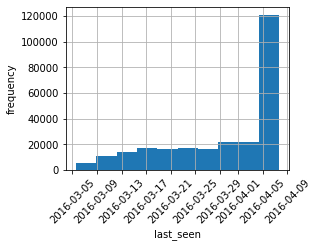

In [44]:
for i in ['date_crawled', 'date_created', 'last_seen']:
    print(f'\n{i:^70}')
    print(df[i].describe())
    df[i].hist(figsize=(4, 3))
    plt.xlabel(i)
    plt.xticks(rotation=45)
    plt.ylabel('frequency')
    plt.show()

In [45]:
df.query('date_created < 2016')['price'].count()

20

Посчитаем число дней между датой объявления и датой последней активности.

In [46]:
df['days_passed'] = (df['last_seen'] - df['date_created']).dt.round('1D').astype("timedelta64[D]")

## Обучение моделей

### Подготовка признаков

#### Удаление ненужных столбцов

In [47]:
# удаляем даты, месяц регистрации, почтовый код, число картинок
df = df.drop(['date_crawled', 'last_seen', 'date_created'], axis=1)
df = df.drop(['registration_month', 'postal_code', 'number_of_pictures'], axis=1)

In [48]:
# отделяем числовые и строковые признаки еще раз, т.к. некоторые колонки исчезли
obj_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type',
       'brand', 'not_repaired']

In [49]:
num_features = ['registration_year',
       'power', 'kilometer',
       'days_passed']

In [50]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,days_passed
0,480,unidentified,1993,manual,0,golf,150000,petrol,volkswagen,unidentified,14.0
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unidentified,23.0
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,1.0
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no,6.0
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,3.0


#### Кодирование категориальных признаков

Проводим порядковое кодирование с помощью Ordinal Encoding, поскольку много категириальных признаков (до сотен)

In [51]:
# копия категириальных признаков для catboost
df_cat = pd.DataFrame()
df_cat = df[obj_features].copy()
df_cat.head(1)

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
0,unidentified,manual,golf,petrol,volkswagen,unidentified


In [52]:
encoder = OrdinalEncoder()
encoder.fit_transform(df[obj_features])
df[obj_features] = encoder.transform(df[obj_features])
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,days_passed
0,480,7.0,1993,1.0,0,115.0,150000,2.0,38.0,1.0,14.0
2,9800,6.0,2004,0.0,163,116.0,125000,2.0,14.0,1.0,23.0
3,1500,5.0,2001,1.0,75,115.0,150000,2.0,38.0,0.0,1.0
4,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0,6.0
5,650,4.0,1995,1.0,102,11.0,150000,2.0,2.0,2.0,3.0


#### Выделение признаков и разбиение

In [53]:
# выделение обучающей выборки
index_train, index_test = train_test_split(
    df.index.values, test_size=0.25, random_state=12345)

# проверка размера
print('Размер обучающей выборки:', df.loc[index_train].shape)
print('Размер валидационной выборки:', df.loc[index_test].shape)

Размер обучающей выборки: (195814, 11)
Размер валидационной выборки: (65272, 11)


In [54]:
target_train = df['price'].loc[index_train]
target_test = df['price'].loc[index_test]

features_train = df.drop('price', axis=1).loc[index_train]
features_test = df.drop('price', axis=1).loc[index_test]

#### Масштабирование количественных признаков

Отмасштабируем числовые признаки с помощью z-преобразования. Таким образом все количественные признаки для алгоритма станут более равноценными.

In [55]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train[num_features])

features_train[num_features] = scaler.transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

In [56]:
features_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,days_passed
291431,4.0,-0.534670,1.0,0.371302,115.0,0.525005,2.0,38.0,0.0,-0.920840
94937,7.0,2.592954,1.0,-0.969654,83.0,-3.359618,2.0,24.0,1.0,-0.920840
91690,7.0,2.592954,0.0,0.858922,6.0,-0.969080,2.0,2.0,0.0,-0.455490
32244,8.0,-0.339193,1.0,0.411937,11.0,0.525005,2.0,2.0,0.0,-0.455490
128150,4.0,-0.339193,1.0,0.452572,135.0,-0.222037,2.0,27.0,0.0,-0.804502


In [57]:
features_train_cat = features_train.drop(obj_features, axis=1).loc[index_train]
features_test_cat =  features_test.drop(obj_features, axis=1).loc[index_test]

In [58]:
features_train_cat[obj_features] = df_cat.loc[index_train]
features_test_cat[obj_features] =  df_cat.loc[index_test]

In [59]:
features_train_cat.head()

,registration_year,power,kilometer,days_passed,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
291431,-0.534670,0.371302,0.525005,-0.920840,sedan,manual,golf,petrol,volkswagen,no
94937,2.592954,-0.969654,-3.359618,-0.920840,unidentified,manual,corsa,petrol,opel,unidentified
91690,2.592954,0.858922,-0.969080,-0.455490,unidentified,auto,1er,petrol,bmw,no
32244,-0.339193,0.411937,0.525005,-0.455490,wagon,manual,3er,petrol,bmw,no
128150,-0.339193,0.452572,-0.222037,-0.804502,sedan,manual,laguna,petrol,renault,no


### Модели

In [60]:
# RMSE
def rmse(true, predicted):
    return mean_squared_error(true, predicted)**.5

rmse_score = make_scorer(rmse, greater_is_better=False)

In [61]:
# Линейная регрессия
def linear_reg(features, target):
    model = LinearRegression()
    result = abs(cross_val_score(model, features, target, scoring=rmse_score, cv=8)).mean()
    return [result, model]

In [62]:
linear_reg(features_train, target_train)

[1822.4710164153385,
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)]

In [63]:
# Дерево решений
def tree(features, target):
    best_model = None
    best_result = 10_000
    for depth in range(7, 23, 2):
        model = DecisionTreeRegressor(random_state=12345, max_depth=depth, min_samples_leaf=20)
        result = abs(cross_val_score(model, features, target, scoring=rmse_score, cv=5)).mean()
        
        if result < best_result:
            best_result = result
            best_model = model
            
    return [best_result, best_model]

In [64]:
# Случайный лес
def forest(features, target):
    best_model = None
    best_result = 10**5
    for depth in [7, 9, 12]:
        for n in [10, 50, 100]:
            model = RandomForestRegressor(random_state=12345, n_estimators=n, max_depth=depth, min_samples_leaf=10)
            result = abs(cross_val_score(model, features, target, scoring=rmse_score, cv=5)).mean()
           
            if result < best_result:
                best_result = result
                best_model = model
    return [best_result, best_model]

In [65]:
# CatBoost
def cat_boost():
    best_model = None
    best_result = 10**5
    
    features_fit_cat, features_valid_cat, target_fit, target_valid= train_test_split(
    features_train_cat, target_train, test_size=0.25, random_state=12345)

    for n in [50, 100, 200]:
        model = CatBoostRegressor(random_state=1, loss_function='RMSE', iterations=n, learning_rate=1, max_depth=7)
        model.fit(features_fit_cat, target_fit, cat_features=obj_features) 
        predicted = model.predict(features_valid_cat)
        result = rmse(target_valid, predicted)

        if result < best_result:
            best_result = result
            best_model = model
            
    return [best_result, best_model]

In [66]:
# LightGBM
def light_gbm(features, target):   
    best_model = None
    best_result = 10**5
    
    features[obj_features] = features[obj_features].astype('category')
    
    for n in [50, 100, 200]:
        model = LGBMRegressor(random_state=1, learning_rate = 0.5, max_depth = 7, n_estimators = n)
        result = abs(cross_val_score(model, features, target, scoring=rmse_score, cv=5)).mean()

        if result < best_result:
            best_result = result
            best_model = model

    return [best_result, best_model]

In [67]:
# функция для происка лучшей модели
def model_search(features, target):
    best_model = None
    best_result = 10_000

    names = {
        'best_linear' : linear_reg(features, target), 
        'best_tree' : tree(features, target), 
        'best_forest' : forest(features, target), 
        'best_light_GBM' : light_gbm(features, target),
        'best_cat_boost' : cat_boost()
    }
    
    best_models = pd.DataFrame([], columns=['model', 'rmse', 'params'])
    
    for model in names:
        best_models.loc[len(best_models.index)] = [model, names[model][0], names[model][1]]
        
        if names[model][0] < best_result:
            best_result = names[model][0]
            best_model = names[model][1]

    return best_models, best_model, best_result

In [68]:
%%time
table, best_model, best_result = model_search(features_train, target_train)

0:	learn: 1611.7136262	total: 246ms	remaining: 12.1s
1:	learn: 1407.0566287	total: 452ms	remaining: 10.9s
2:	learn: 1326.9434203	total: 649ms	remaining: 10.2s
3:	learn: 1285.2482301	total: 850ms	remaining: 9.78s
4:	learn: 1244.2061173	total: 1.05s	remaining: 9.43s
5:	learn: 1221.0049098	total: 1.25s	remaining: 9.16s
6:	learn: 1203.5466684	total: 1.45s	remaining: 8.89s
7:	learn: 1191.1191162	total: 1.64s	remaining: 8.63s
8:	learn: 1175.8966116	total: 1.84s	remaining: 8.38s
9:	learn: 1166.6342367	total: 2.04s	remaining: 8.15s
10:	learn: 1157.8760781	total: 2.24s	remaining: 7.93s
11:	learn: 1154.0591840	total: 2.35s	remaining: 7.43s
12:	learn: 1142.6483024	total: 2.54s	remaining: 7.24s
13:	learn: 1135.0185156	total: 2.74s	remaining: 7.05s
14:	learn: 1130.7648298	total: 2.94s	remaining: 6.86s
15:	learn: 1125.5452213	total: 3.13s	remaining: 6.66s
16:	learn: 1120.9495885	total: 3.33s	remaining: 6.47s
17:	learn: 1118.2957162	total: 3.44s	remaining: 6.12s
18:	learn: 1112.4733618	total: 3.64s	r

In [69]:
table

,model,rmse,params
0,best_linear,1822.471016,"LinearRegression(copy_X=True, fit_intercept=Tr..."
1,best_tree,1182.265819,"DecisionTreeRegressor(criterion='mse', max_dep..."
2,best_forest,1148.081254,"RandomForestRegressor(bootstrap=True, criterio..."
3,best_light_GBM,1030.727866,"LGBMRegressor(boosting_type='gbdt', class_weig..."
4,best_cat_boost,1063.655967,<catboost.core.CatBoostRegressor object at 0x7...


## Анализ моделей

Для лучших моделей подсчитаем время обучения и предсказания

In [70]:
class model_timer:
    
    def fitting(self, features_train, target_train):
        """
        Замеряем время обучения
        """
        time_fit = []
        for model in table['params'][:-2]:
            t = time.time()
            model.fit(features_train, target_train)
            delta = round((time.time() - t), 2)
            time_fit.append(delta)    

        lgbm = table.loc[3, 'params']
        features_train[obj_features] = features_train[obj_features].astype('category')
        t = time.time()
        lgbm.fit(features_train, target_train)
        delta = round((time.time() - t), 2)
        time_fit.append(delta)
        
        cat = table.loc[4, 'params']
        t = time.time()
        cat.fit(features_train_cat, target_train, cat_features=obj_features)
        delta = round((time.time() - t), 2)
        time_fit.append(delta)
        
        return time_fit
            
    def prediction(self, features_test, target_test):
        """
        Замеряем время предсказания и заодно rmse на тестовой выборке
        """
        time_predict = []
        rmse_predict = []
        for model in table['params'][:-2]:
            t = time.time()
            predicted = model.predict(features_test)
            delta = round((time.time() - t), 2)
            time_predict.append(delta)
            
            result = rmse(target_test, predicted)
            rmse_predict.append(result)
            
        lgbm = table.loc[3, 'params']
        features_test[obj_features] = features_test[obj_features].astype('category')
        t = time.time()
        predicted = lgbm.predict(features_test)
        delta = round((time.time() - t), 2)
        time_predict.append(delta)

        result = rmse(target_test, predicted)
        rmse_predict.append(result)
        
        cat = table.loc[4, 'params']
        t = time.time()
        predicted = cat.predict(features_test_cat)
        delta = round((time.time() - t), 2)
        time_predict.append(delta)

        result = rmse(target_test, predicted)
        rmse_predict.append(result)
            
        return time_predict, rmse_predict


In [ ]:
model_timer = model_timer()
table['time_fit'] = model_timer.fitting(features_train, target_train)

In [72]:
table['time_predict'] = model_timer.prediction(features_test, target_test)[0]
table['test_rmse'] = model_timer.prediction(features_test, target_test)[1]

In [73]:
table['total_time'] = table['time_fit'] + table['time_predict']


                        DecisionTreeRegressor                         


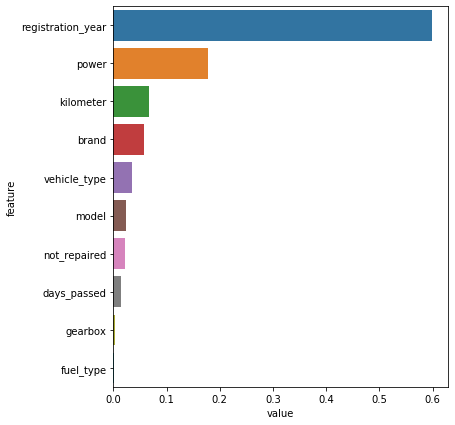


                        RandomForestRegressor                         


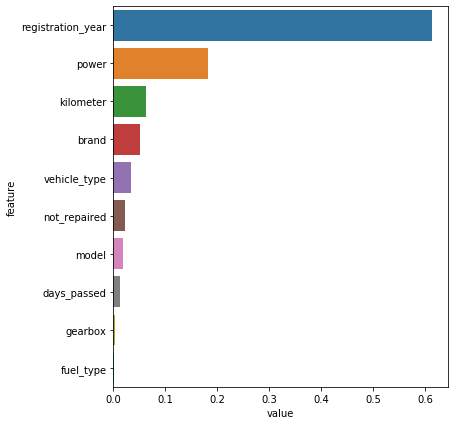


                            LGBMRegressor                             


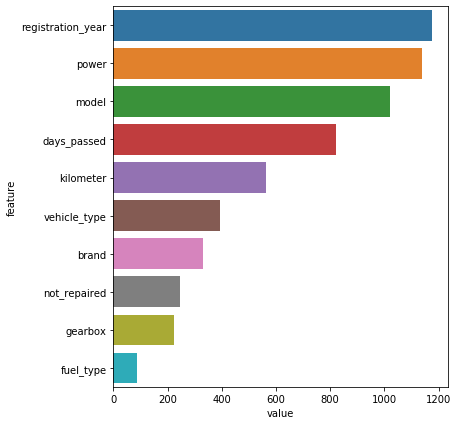


                          CatBoostRegressor                           


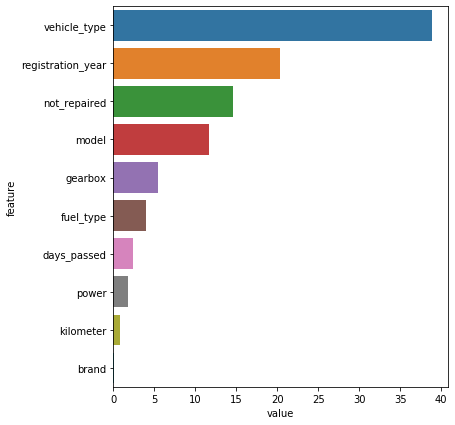

In [74]:
# feat_importance 
for model in table.loc[1:,'params']:
    print(f'\n{model.__class__.__name__:^70}')
    # строим таблицу из признаков и их важности
    feat_importance = pd.DataFrame()
    feat_importance["feature"] = df.drop('price', axis=1).columns
    feat_importance["value"] = model.feature_importances_
    feat_importance.sort_values(by='value', ascending=False, inplace=True)
    # строим график
    plt.figure(figsize=(6,7))
    ax = sns.barplot(y="feature", x="value", data=feat_importance)
    plt.show()

In [75]:
comparison_table = table.drop('params', axis=1)
comparison_table

,model,rmse,time_fit,time_predict,test_rmse,total_time
0,best_linear,1822.471016,0.17,0.00,1828.203775,0.17
1,best_tree,1182.265819,0.79,0.06,1167.849032,0.85
2,best_forest,1148.081254,31.98,0.79,1142.734363,32.77
3,best_light_GBM,1030.727866,6.53,0.80,1016.522920,7.33
4,best_cat_boost,1063.655967,103.53,0.38,1051.866764,103.91


На тестовых выборках значения rmse меньше, видимо, из-за недообучения

In [76]:
final_model = table.loc[3, 'params']

**Вывод**

Лучшее соотношение быстрота/точность у модели следующей модели:

In [77]:
final_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=7,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
              random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Вывод

Для построения модели для определения стоимости автомодиля необходимо было решить задачу регрессии, при этом необходимо было учитывать скорость обучения и прогнозирования и точность прогноза.

Ход работы: 
1. Данные загружены, проведен первичный осмотр. Обнаружено следующее:
    - Есть пропуски в трех колонках типа object: VehicleType, Gearbox, Model, FuelType, NotRepaired
    - Стиль названия колонок не соответсвуем snake_case
    - Колонки с датами и временем имеют строковый тип данных (что не всегда является проблемой)
    
2. Подготовка данных:
    1. Стиль названия колонок приведен к snake_case
    2. Обработаны пропуски: заполнены значением "unidentified", поскольку все пропуски в столбцах с типом данных object и достоверного способа восстановить их нет
    3. Проведена проверна на наличие дубликатов. Выявлено 4 строки-дубликата (удалены).
    4. Проведен первичный анализ.

3. Подготовлены признаки.
    1. Удалены столбцы, которые не являются признаками: 
    2. Категориальные данные преобразованы в числовые (порядковое кодирование в силу большого числа групп)
    3. Выделен целево признак
    4. Данные разбиты на обучающую и тестовую выборку (4:1)
    5. Отмасштабированы количесвенные признаки

4. Построены модели: 
    - линейная регрессия
    - дерево решений
    - случайный лес
    - CatBoost
    - LightGBM
5. Выбраны гиперпараметры для получения наименьшего RMSE
6. Для лучших моделей вычислено время обучения и прогнозирования

In [78]:
comparison_table

,model,rmse,time_fit,time_predict,test_rmse,total_time
0,best_linear,1822.471016,0.17,0.00,1828.203775,0.17
1,best_tree,1182.265819,0.79,0.06,1167.849032,0.85
2,best_forest,1148.081254,31.98,0.79,1142.734363,32.77
3,best_light_GBM,1030.727866,6.53,0.80,1016.522920,7.33
4,best_cat_boost,1063.655967,103.53,0.38,1051.866764,103.91


Для решения задачи лучше всего подходит модель 

In [79]:
final_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.5, max_depth=7,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
              random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)